In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("proj2b.ipynb")

# Email Spam/Ham Classification

## Feature Engineering, Classification, Cross Validation

## Overview
In this project, I will be building and improving on the concepts of Logistic Regression to create my own classifier to distinguish spam emails from ham (non-spam) emails. I will evaluate my work based on my model's accuracy.

In this project, I will:

- Use `sklearn` libraries to process data and fit models
- Validate the performance of your model and minimize overfitting
- Generate and analyze precision-recall curves

## Warning
This is a **real world** dataset– the emails I am trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. I think the benefit of working with realistic data outweighs these inappropriate emails, and therefore I wanted to give a warning at the beginning of the project.

In [2]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Setup and Recap

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading and Cleaning Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). The labeled training dataset contains 8348 labeled examples, and the unlabeled test set contains 1000 unlabeled examples.

Let's run the following cell to load in the data into DataFrames.

The `train` DataFrame contains labeled data that I will use to train my model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. I will predict labels for these emails and report predictions.

In [4]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [5]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lower case as a first step to processing the text

#original_training_data['email'] = original_training_data['email'].str.lower()
#test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,URL: http://boingboing.net/#85534171\n Date: N...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",URL: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<HTML>\n <HEAD>\n </HEAD>\n <BODY>\n <FONT SIZ...,1
3,3,Subject: liberal defnitions\n,Depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Keep in mind that our data may contain missing values, which are handled in the following cell.

In [6]:
# Fill any missing or NAN values
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


### Training/Validation Split

The training data we downloaded is all the data we have available for both training models and **validating** the models that we train. We therefore split the training data into separate training and validation datsets. We will need this **validation data** to assess the performance of my classifier once I am finished training. 

We will set the seed (random_state) to 42.

In [7]:
# This creates a 90/10 train-validation split on our labeled data
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts
train = train.reset_index(drop = True)

### Feature Engineering

In order to train a logistic regression model, we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$. To address this, I implemented the function `words_in_texts`, which creates numeric features derived from the email text and uses those features for logistic regression. 

The function outputs a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

In [8]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    import numpy as np
    indicator_array = 1 * np.array([texts.str.contains(word) for word in words]).T
    return indicator_array

Let's run the following cell to see how the function works on some dummy text.

In [9]:
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

### EDA and Basic Classification

Let's visualize the frequency of different words for both spam and ham emails, and use `words_in_texts(words, train['email'])` to directly train a classifier. I will also provide a simple set of 5 words that might be useful as features to distinguish spam/ham emails. 

Run the following cell to see the performance of a simple model using these words and the `train` dataframe.

In [10]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = 'lbfgs')
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7532277385864502


### Evaluating Classifiers

In our models, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. Below is a reference to the various metrics we can use to evaluate a classifier.

This classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

Below are two graphics of precision and recall:

![precision_recall](precision_recall.png)

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

# Moving Forward - Building Your Own Model

With this in mind, we will now make the spam filter more accurate. My personal goal for this project is to build a classifier that obtains at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Gradescope.

**Gradescope limits you to four submissions per day**. You will be able to see your accuracy on the entire test set when submitting to Gradescope.

Here are some ideas I considered for this model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. We can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

---

## Feature Engineering and Data Cleaning

In [12]:
# function that takes in a dataframe and returns each unique word among all the strings in the 'email' column 
# and the respective number of times that word appeared in an email classified as 'spam' 

def best_words(toy_df):
    listt = []
    for i in toy_df.index:
        for w in pd.Series(toy_df.loc[i, 'email']).str.split(' ')[0]:
            if w not in listt:
                listt = np.append(listt, w)

    sums = []
    for word in listt:
        word_df = toy_df[toy_df['email'].str.contains(word, regex = False)]
        word_sum = np.sum(word_df['spam'])
        sums = np.append(sums, word_sum)

    word_and_mean = pd.DataFrame({'word' : listt,
                             'spam total count' : sums})

    return (word_and_mean.sort_values('spam total count', ascending = False))

In [13]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts

## ran this cell multiple times to help fill my `words` list

train_random_100 = train.sample(50, axis = 0, replace = False)
train_random_100['email'] = train_random_100['email'].str.lower()

dff = best_words(train_random_100)
dff[dff['spam total count'] == max(dff['spam total count'])]

,word,spam total count
3844,l,9.0
4145,e,9.0
101,mail,9.0
33,or,9.0
3034,t,9.0
36,i,9.0
39,to,9.0
45,it,9.0
48,\n,9.0
445,",",9.0


In [14]:
### building more features

# array of percentage of capital letters in each email
email_capital = train['email'].str.findall(r'[A-Z]').str.len()
email_capital

# convert emails in both train and test to lowercase for other features
train['email'] = train['email'].str.lower()
val['email'] = val['email'].str.lower()

# array of number of ? in each email
arr_ques = train['email'].str.count(r'\?')

# array of character lengths for each email
arr_email_len = train['email'].str.len()

# array of number of $ in each email
arr_dollar = train['email'].str.count(r'\$') 

# array of number of 'free' per email
arr_free = train['email'].str.count(r'free')

# Final X matrix and Fitting Model

In [15]:
# words below determined from a using the best_words function I wrote above on random 50 rows from `train` multiple times; additionally,
# i went threw some emails classified as spam myself to find phrases I thought were common.

words = ['<br>', 'font', 'sex', 'membership', 'live sex cams', 
         'linedrawn', 'transfer.', 'honesty', 'whether', 'opportunity', 
         'reasonable', 'benificiary', 'phone:', 'customer:', 
         'reap', '0', '3', '5', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
        'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
        'x', 'y', 'z', '/', 'in', ':', 'al', 'di', 'et', 'ed', 'es', 'mail',
        'im', 'tt', 'our', 'as', '.', 'he', 'we', 'le', 'http', '//', '!!', '!!!', '\n', 
         'html', 'please', r'^url:', '<head>', 'ac', 'ne', 'ca', '-', 'ou', 'nt', 'si', 'il', 'co']

X_trainn = words_in_texts(words, train['email'])
Y_trainn = train['spam'].to_numpy()

#add other features
X_trainn = np.concatenate((X_trainn, arr_ques[:, None]), 1)
X_trainn = np.concatenate((X_trainn, arr_email_len[:, None]), 1)
X_trainn = np.concatenate((X_trainn, email_capital[:, None]), 1)
X_trainn = np.concatenate((X_trainn, arr_dollar[:, None]), 1)
X_trainn = np.concatenate((X_trainn, arr_free[:, None]), 1)


from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_trainn)
X_scaled = scaler.transform(X_trainn)

In [16]:
from sklearn.linear_model import LogisticRegressionCV
modell = LogisticRegressionCV(fit_intercept = True, cv = 10, solver = 'lbfgs', penalty = 'l2')
modell.fit(X_scaled, Y_trainn)

training_accuracyy = modell.score(X_scaled, Y_trainn)
print("Training Accuracy: ", training_accuracyy)

Training Accuracy:  0.9241315053906562


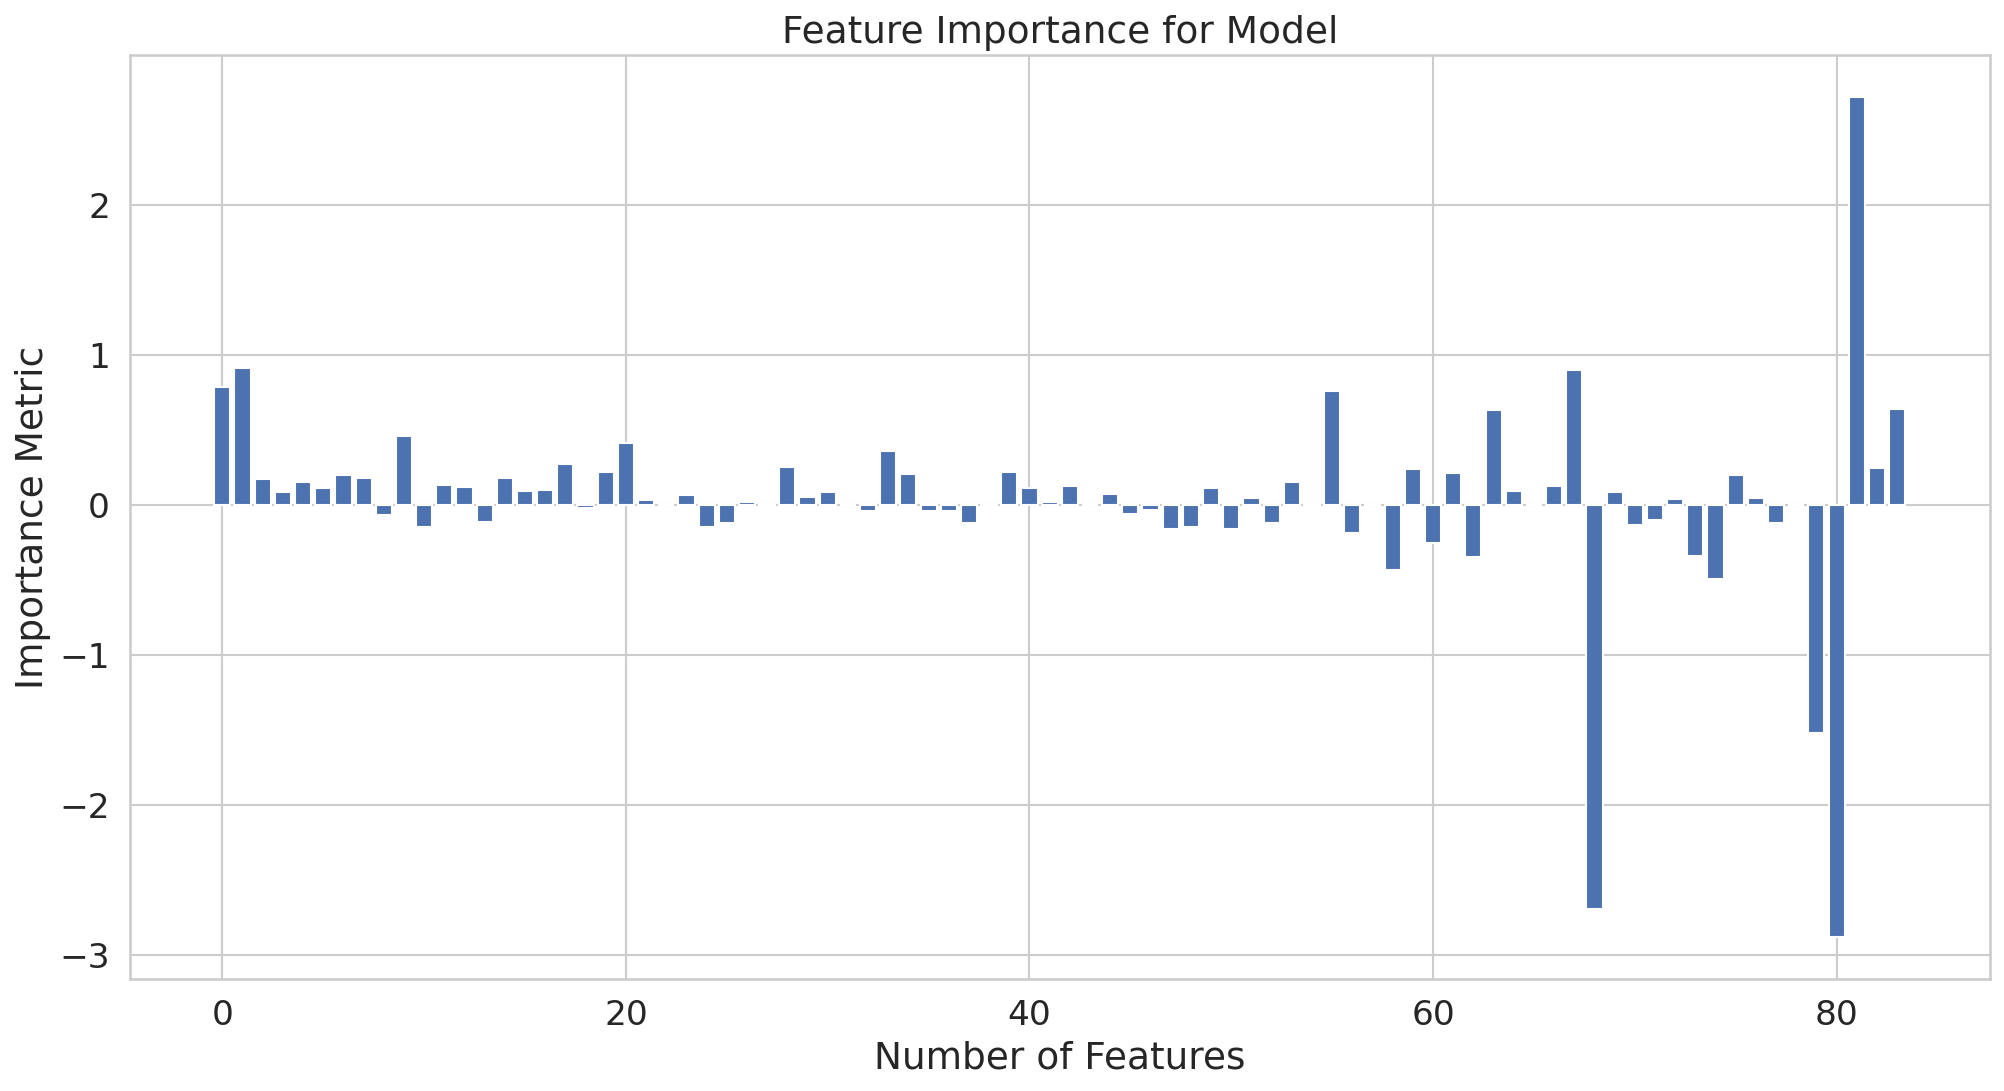

In [17]:
imptance = modell.coef_[0]

plt.bar([X for X in range(len(imptance))], imptance)
plt.title("Feature Importance for Model")
plt.xlabel("Number of Features")
plt.ylabel("Importance Metric")
plt.show()

In [18]:
# feature processing and engineering function

def log_reg_process_data(data):
    # array of number of capital letters in each email
    email_capital = data['email'].str.findall(r'[A-Z]').str.len()
    
    # convert emails in data to lowercase for other features
    data['email'] = data['email'].str.lower()

    # array of number of ! in each email
    arr_ques = data['email'].str.count(r'\?')

    # array of number of <head> in each email
    arr_head = data['email'].str.count(r'<head>')

    # array of number of <html> in each email
    arr_html = data['email'].str.count(r'html')

    # array of character lengths for each subject
    arr_sub_len = data['subject'].str.len()

    # array of character lengths for each email
    arr_email_len = data['email'].str.len()

    # array of # of words in each email
    arr_email_words = data['email'].str.split(' ').str.len()
    
    # array of number of capital letters in subject out of all letters in subject
    subject_capital = data['subject'].str.findall(r'[A-Z]').str.len()
    
    # whether email is a reply or forwarded
    reply_or_forward = 1 * np.array([data['subject'].str.lower().str.contains(word) for word in ['re:', 'fwd:']]).T
    
    # array of number of $ in each email
    arr_dollar = data['email'].str.count(r'\$') 
    
    # array of number of 'free' per email
    arr_free = data['email'].str.count(r'free')

    
    #words = ['body', 'html', '<head>', '<br>', 'font', 'please', '\n']
    #words = ['html', '<br>', 'font', 'please']
    words = ['<br>', 'font', 'sex', 'membership', 'live sex cams', 
         'linedrawn', 'transfer.', 'honesty', 'whether', 'opportunity', 
         'reasonable', 'benificiary', 'phone:', 'customer:', 
         'reap', '0', '3', '5', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
        'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
        'x', 'y', 'z', '/', 'in', ':', 'al', 'di', 'et', 'ed', 'es', 'mail',
        'im', 'tt', 'our', 'as', '.', 'he', 'we', 'le', 'http', '//', '!!', '!!!', '\n', 
         'html', 'please', r'^url:', '<head>', 'ac', 'ne', 'ca', '-', 'ou', 'nt', 'si', 'il', 'co']

    X_val = words_in_texts(words, data['email'])


    #add other two features
    X_val = np.concatenate((X_val, arr_ques[:, None]), 1)
    #X_val = np.concatenate((X_val, arr_head[:, None]), 1)
    #X_val = np.concatenate((X_val, arr_sub_len[:, None]), 1)
    X_val = np.concatenate((X_val, arr_email_len[:, None]), 1)
    #X_val = np.concatenate((X_val, arr_html[:, None]), 1)
    #X_val = np.concatenate((X_val, subject_capital[:, None]), 1)
    #X_val = np.concatenate((X_val, reply_or_forward), 1)
    X_val = np.concatenate((X_val, email_capital[:, None]), 1)
    X_val = np.concatenate((X_val, arr_dollar[:, None]), 1)
    X_val = np.concatenate((X_val, arr_free[:, None]), 1)

    scaler_val = preprocessing.StandardScaler().fit(X_val)
    X_scaled_val = scaler_val.transform(X_val)
    
    return(X_scaled_val)

<!-- BEGIN QUESTION -->

### Question 1: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q1
manual: True
points: 6
-->

_1. I found better features by focusing first on the words I was going to pass through the `words_in_texts` function. To do this, I created the `best_words` function, which when given a dataframe as input with a column of string values named `email` and a column of 0's and 1's named `spam`, returns a data frame with every unique word in the `email` column, sorted in descending order by a column named `spam total count` which corresponds to the respective number of times each word appears in an email corresponding to a value of 1 in the `spam` column. Additionally, I created my own features which capture things such as the number of capital letters in an email, the number of question marks in an email, the length of an email, the number of dollar signs in an email, and the number of times the word 'free' appears in an email; I tested each of these features out by making a plot of the feature and the `spam` column to see the distribution of the features' values for 0's and 1's in the `spam` column of `train`._

_2. Initially, I tried running my `best_words` function on the entirety of `train`, but my kernel crashed. Therefore, instead I decided to run the function on a random sample of 50 rows from `train` many times manually, to capture different words that were prevelant among emails corresponding to a value of 1 in the `spam` column._

_3. Something surprising in my search for good features were that individual letters in the alphabet correspond to spam emails. Additionally, when plotting the distribution of my other features to see whether they had different values for different types of emails, I saw that most of them had similar values for both spam and ham emails, with the exception of outliers. I believe this might be because most spam emails are generated in a way where the number of occurences of certain things my features captured (such as the number of dollar signs, or the word 'free' for instance) are the same; therefore, they appear as outliers, when they actually are just overlap due to multiple observations of the same number. Regardless, these features still proved to be useful in my model._

<!-- END QUESTION -->



Optional: Build a Decision Tree model with reasonably good accuracy. What features does the decision tree use first?

## Exploratory Data Analysis

<!-- BEGIN QUESTION -->

#### Question 2a

Generate your visualization in the cell below.

<!--
BEGIN QUESTION
name: q2a
manual: True
format: image
points: 4
-->

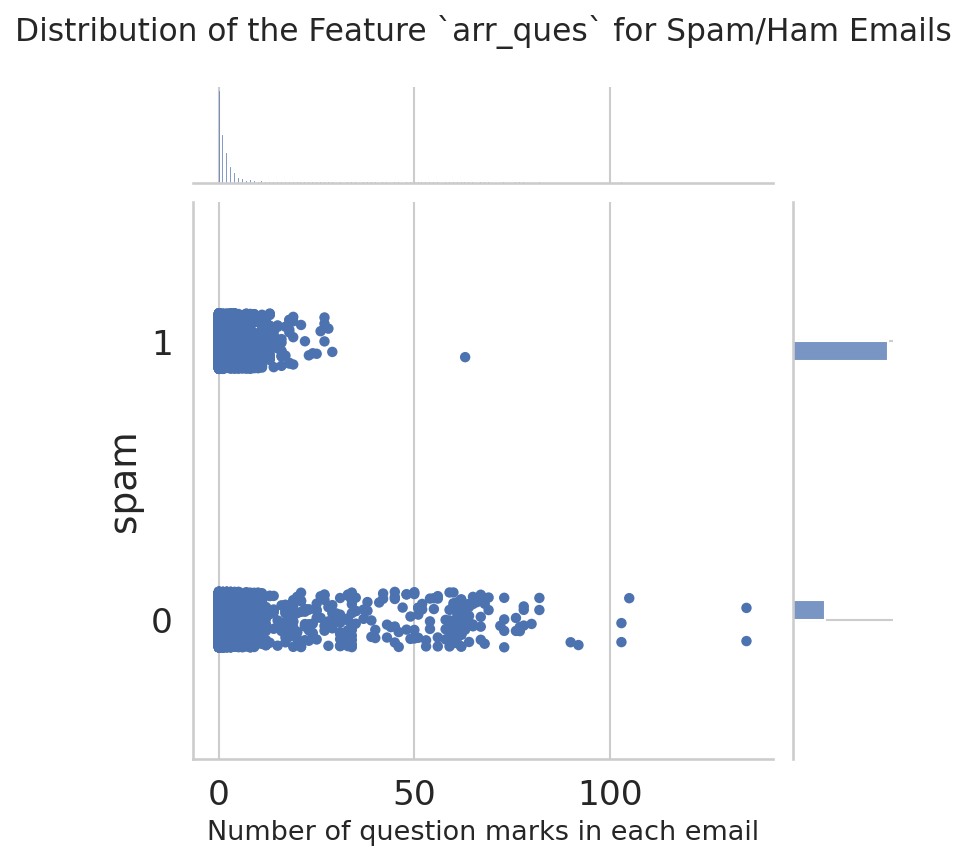

In [19]:
g = sns.JointGrid(arr_ques, train['spam'])
plt.suptitle('Distribution of the Feature `arr_ques` for Spam/Ham Emails', size = 15)
plt.subplots_adjust(top=0.9)
g.plot_marginals(sns.histplot)
g.plot_joint(sns.stripplot,
             orient='h', order=[1, 0],
             color=sns.color_palette()[0])
g.ax_joint.set_xlabel("Number of question marks in each email", size = 13)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Question 2b

Write your commentary in the cell below.

<!--
BEGIN QUESTION
name: q2b
manual: True
points: 2
-->

_For my features that were seperate from the `words_in_texts` function, I plotted a jointgrid plot of the distribution of the feature for spam and ham emails. By doing so, I was able to analysis the linear seperability of the data and whether or not I observed different values of the feature for spam vs ham emails, so that I was able to tell whether the feature would be useful or not. As we can see with the plot above, we observe many higher values for ham emails for the feature which counts the number of questions marks per email. Additionally, the plot tells us that the data with this feature aren't linearly seperable, so it is a good feature to use in our model._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3: ROC Curve

In most cases we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late, whereas a patient can just receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot a ROC curve for your final classifier (the one you use to make predictions for Gradescope) on the training data. Refer to Lecture 20 to see how to plot an ROC curve.

**Hint**: You'll want to use the `.predict_proba` method for your classifier instead of `.predict` so you get probabilities instead of binary predictions.

<!--
BEGIN QUESTION
name: q3
manual: True
points: 3
-->

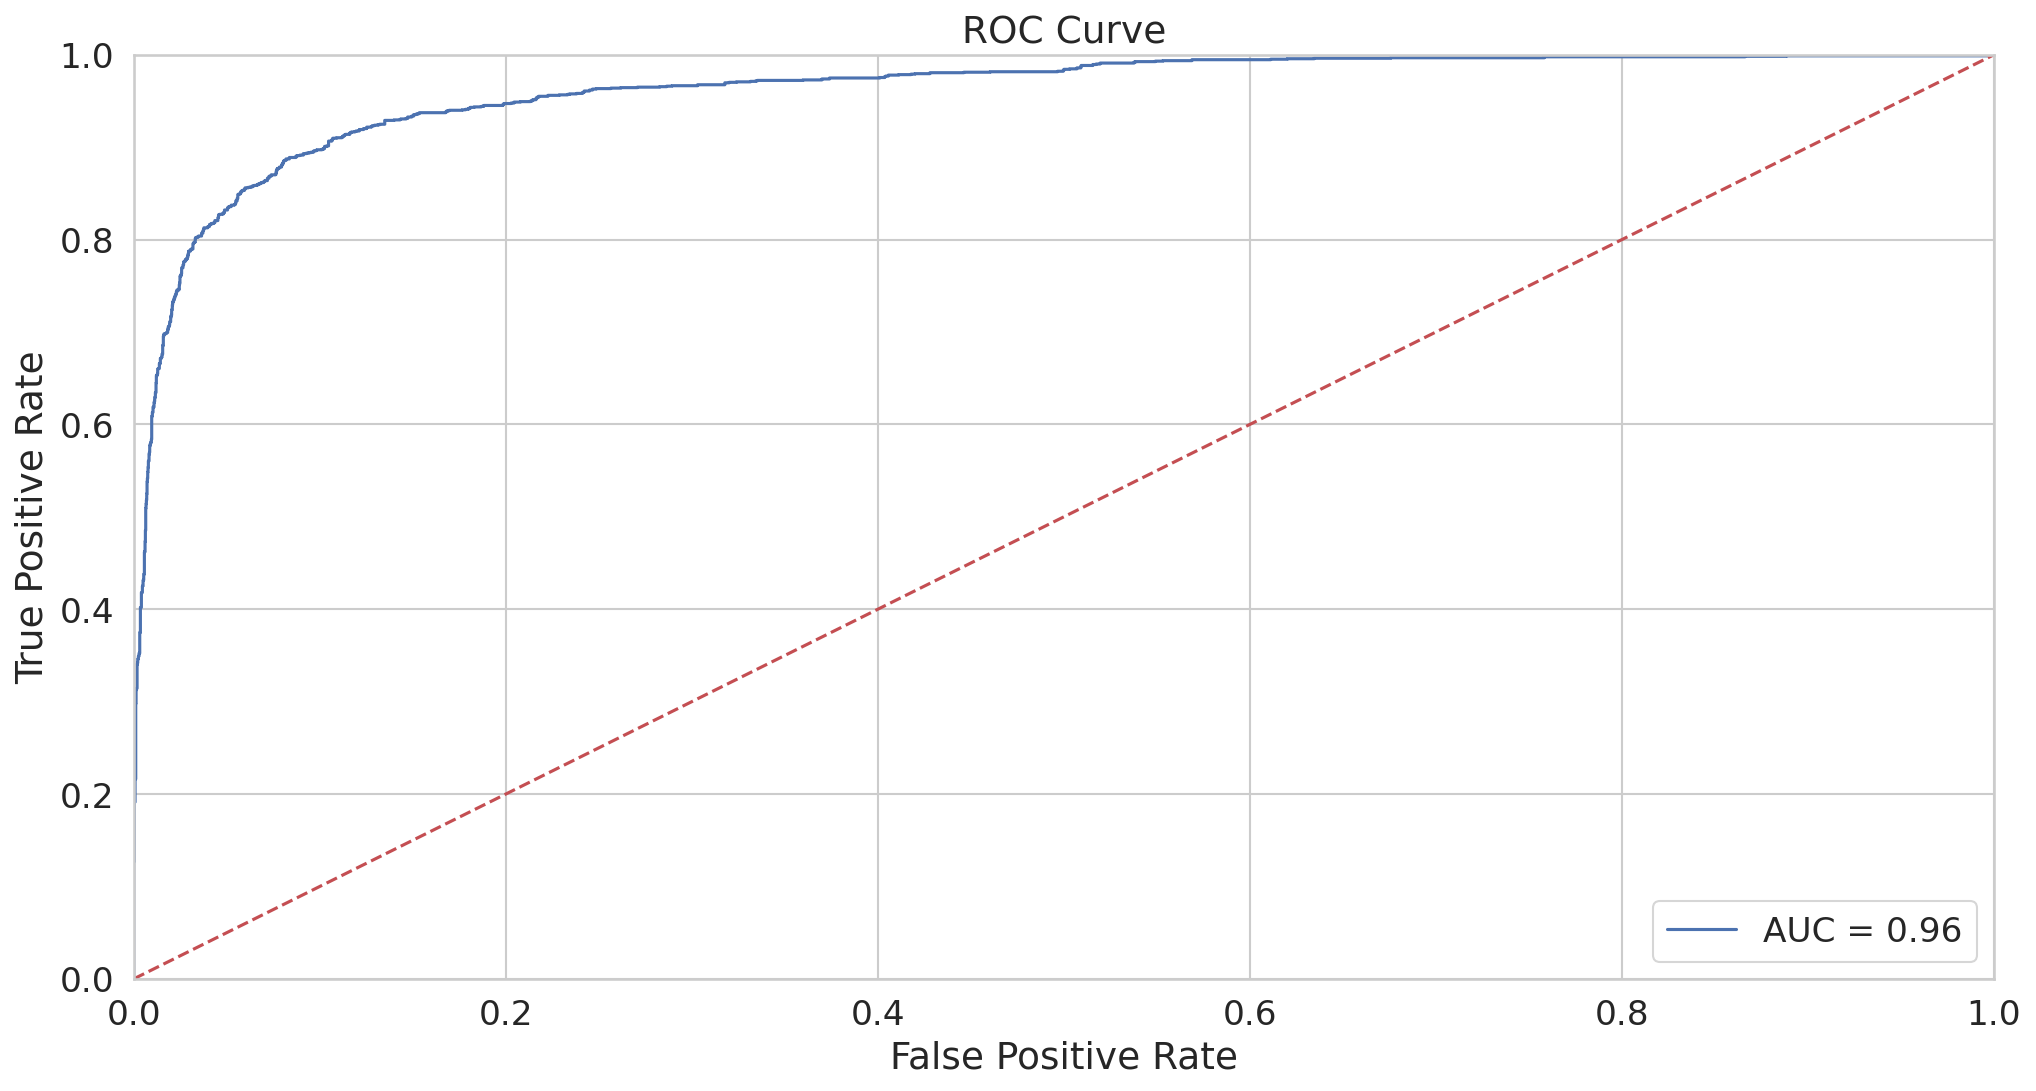

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

probs = modell.predict_proba(X_scaled)
predictions = probs[:, 1]


fpr, tpr, thresholds = roc_curve(train['spam'], predictions)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<!-- END QUESTION -->

# Question 4: Test Predictions

The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to the "Project 2B Test Predictions" assignment on Gradescope to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions`. **Please make sure you've saved your predictions to `test_predictions` as this is how part of your score for this question will be determined.**

**Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions.** For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

**Note: You may submit up to 4 times a day. If you have submitted 4 times on a day, you will need to wait until the next day for more submissions.**

Note that this question is graded on an absolute scale based on the accuracy your model achieves on the overall test set, and as such, your score does not depend on your ranking on Gradescope.

*The provided tests check that your predictions are in the correct format, but you must additionally submit to Gradescope to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q4
points: 3
-->

In [21]:
test_predictions = modell.predict(log_reg_process_data(test))

In [22]:
grader.check("q4")

RuntimeError: Malformed test file: does not define the global variable 'OK_FORMAT'

The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Project 2B Test Predictions" assignment on Gradescope to get credit for this question.** There are a maximum of 4 attempts per day of submitting to this assignment, so please use them wisely!

Note that the file will appear in your DataHub, you must navigate to the `proj2b` directory in your DataHub to download the file.

In [23]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Gradescope for scoring.')

Created a CSV file: submission_2023-07-08T19:39:29.csv.
You may now upload this CSV file to Gradescope for scoring.


## Congratulations! You have completed Project 2B!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [24]:
grader.check_all()

RuntimeError: Malformed test file: does not define the global variable 'OK_FORMAT'

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [25]:
# Save your notebook first, then run this cell to export your submission.
grader.export()